In [1]:
from math import *
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import newton
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


The initial conditions are given by
$$
x[0]~=~ 0, ~~~ y[0] ~=~ 0
$$
$$ 
v_x[0] ~=~ v * cos(\theta),  ~~~ v_y[0] ~=~ v * sin(\theta)
$$

And the differential equation is
$$
\frac{d}{dt} 
\begin{bmatrix} 
x \\
y \\
v_x \\
v_y \\
\end{bmatrix}
 ~=~
 \begin{bmatrix} 
v_x \\
v_y \\
-\mu v_x \sqrt{v_x^2 + v_y^2} \\
-g -\mu v_y \sqrt{v_x^2 + v_y^2}\\
\end{bmatrix}
$$


$$
D( ): R^k ~~\rightarrow ~~ RxR^k
$$
$$
Integrate( ): R^k ~~\rightarrow  [V_0, V_1, ... ,V_n] \in R^k
$$

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy


In [3]:
# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
alpha0  = radians(75)  # Launch angle (deg.)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m


projectile_motion computes the xy and vxy of the path at point t by integrating from 0.
makepath below takes the initial anlgle and speed and computes the trajectory intil it returns to earth.

In [4]:
def makepath(angle, vel):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    #use newton to find the zero of the function for the y component of the velocity [3][1] starting from 0
    T_peak = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[3][1], 0)
    y_peak = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, T_peak])[1][1]
    #use newton to find the zero of the y position starting from 2*T_peak
    T = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[1][1], 2 * T_peak)
    #print(T, 2*T_peak)
    t = np.linspace(0, T, 101)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, T

In [5]:
X = np.zeros((101))
Y = np.zeros((101))
X, Y, T = makepath(30, 500.0)

No handles with labels found to put in legend.


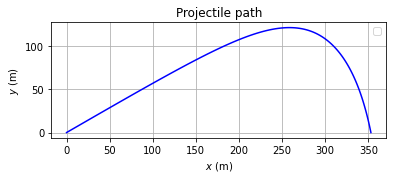

In [6]:
# Plot of trajectory
fig, ax = plt.subplots()
#for i in range(20):
ax.plot(X[:],Y[:] , "b-")
ax.set_title(r"Projectile path")
ax.set_aspect("equal")
ax.grid(b=True)
ax.legend()
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.savefig("01 Path.png")

The following is one of the simplest recurrent networks you can create!

In [7]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(2, 100)
        self.linear = nn.Linear(100, 2)
        self.c_h = (torch.zeros(1,1,100),
                    torch.zeros(1,1,100))
    def forward(self, x):
        h, self.c_h= self.lstm(x.view(len(x) ,1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

$$
Model( ): (R^2)^{10} ~~\rightarrow  [V_0, V_1, ... ,V_n] \in R^2
$$

In [8]:
use_saved_model = True
if use_saved_model:
    model = MyLSTM()
    model.load_state_dict(torch.load('lstm-modelave_newer3')) 
else:
    torch.save(model.state_dict(), 'lstm-modelave_newer2')


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))


The following is used to create a training set from a path of points.

In [10]:
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

OneStep takes a computed path and generates a version created by the lstm.  it does this by taking the first 10 items in the input data path as input to the lstm and then pushes ahead one prediction at a time.  It truncates the new sequence when the y axis is negative.  

In [11]:
def OneStep(data):
    print('data set length =', len(data))
    train_window = 10
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 2))
    fut_pred = len(data)# -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window,2).tolist()
    #print(test_inputs)
    s2 = train_data_normalized.reshape(len(data),2).tolist()
    realdata = data
    model.eval()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        #print(seq)
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq)
        new_point = x.detach().numpy()
        t2.append(new_point)
    #print(preds)
    actual_predictions = scaler.inverse_transform(np.array(t2 ).reshape(-1,2))
    #print(t2)
    print(len(actual_predictions))
    plt.figure( figsize=(10,5))
    plt.plot(data[:,0], data[:,1], color='b')
    maxt = len(actual_predictions)
    for i in range(len(actual_predictions)):
        if actual_predictions[i,1]< 0:
            actual_predictions[i,1] =0
            maxt = i
            break
    mods = np.zeros((maxt,2))
    mods[0:maxt] = actual_predictions[0:maxt]
    plt.plot(mods[:,0], mods[:,1], color = 'g')
    #plt.plot(actual_predictions[:,0],actual_predictions[:,1] , color='g')
    err = 0.0
    errs = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0
    maxerr = 0.0
    maxloc = 0
    for i in range(min(101,maxt)):
        er =np.linalg.norm(realdata[i]-mods[i])
        err += er
        if er > maxerr:
            maxerr = er
            maxloc = i
    print("mean error =", err/101)
    print('maxerr =', maxerr, ' at ', maxloc)
    return actual_predictions[:maxt]

In [12]:
#compute a trajectory at angle and speed
def makeX(angle, speed):
    X = np.zeros((101))
    Y = np.zeros((101))
    X, Y, T = makepath(angle, speed)
    x = np.zeros((len(X), 2))
    for i in range(len(X)):
        x[i,0]= X[i]
        x[i,1]= Y[i]
    return x,  T

In [13]:
x, T = makeX(35, 500)


calling OneStep will compute the lstm solution and plot the ODEsolver solution (blue) and the LSTM solution green.

data set length = 101
111
mean error = 5.100079794543877
maxerr = 10.707343327283562  at  100


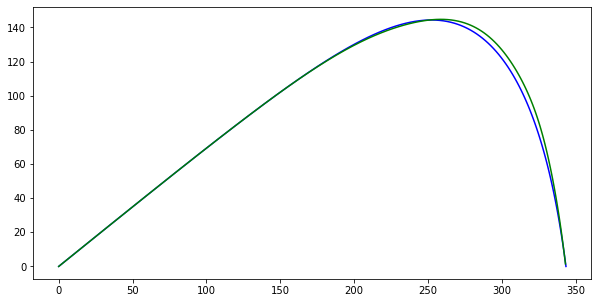

In [14]:
p = OneStep(x)

data set length = 101
111
mean error = 0.5676186205560654
maxerr = 1.4658544885774367  at  99


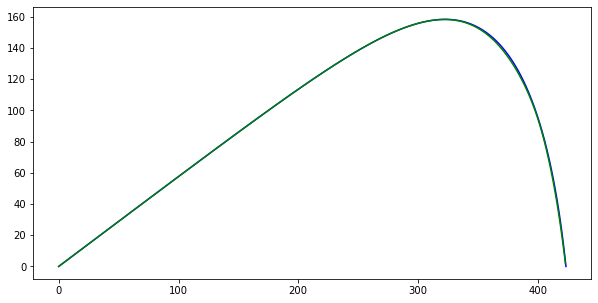

In [15]:
x, T = makeX(30,1000)
p = OneStep(x)

The original saved model was created with a single path. of 30 degrees, speed = 1000

The following 2 cells creates the training set used here.  There were 4 paths 

40 degrees speed = 1000

40 degrees speed = 500

25 degrees speed = 1000

25 degrees soeed = 500

In [17]:
def make_inout_seq2(algle, speed):
    X, Y , T = makepath(algle, speed)
    x = np.zeros((101, 2))
    for i in range(101):
        x[i,0]= X[i]
        x[i,1]= Y[i]
    path = x
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(x.reshape(-1, 2))
    train_six_normalized =[]
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    train_window = 10
    train_inout_seq = create_inout_sequences(train_data_normalized.reshape(101,2), train_window)
    return path, train_inout_seq

In [18]:

pa, train_inout_seq = make_inout_seq2(10+2*15, 1000)
len(train_inout_seq)
pa, train_inout_seq2 = make_inout_seq2(10+2*15, 500)
train_inout_seq += train_inout_seq2
pa, train_inout_seq3 = make_inout_seq2(10+15, 1000)
train_inout_seq += train_inout_seq3
len(train_inout_seq)
pa, train_inout_seq4 = make_inout_seq2(10+15, 500)
train_inout_seq += train_inout_seq4
len(train_inout_seq)

364

In [38]:
#this will train for a single path (by retraining the saved model)
pa, train_inout_seq = make_inout_seq2(30, 1000)
use_saved_model = False

In [30]:
if use_saved_model == False:
    loss_function = nn.MSELoss()
    hidden_layer_size = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    epochs =4002 #52

    for i in range(epochs):
        seq_err = 0.0
        for _ in range(500):
            num = np.random.randint(len(train_inout_seq))
            seq = train_inout_seq[num][0]
            labels = train_inout_seq[num][1]
            optimizer.zero_grad()
            model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                            torch.zeros(1, 1, hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred.reshape(1,2), labels)
            single_loss.backward()
            optimizer.step()
            seq_err+= single_loss.item()
        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            print(f'seq: {i:3} loss: {seq_err:10.8f}')
        if seq_err < 0.000007:
            break

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    torch.save(model.state_dict(), 'lstm-modelave_newer3')
    

epoch:   1 loss: 0.00000051
seq:   1 loss: 0.00002131
epoch:  26 loss: 0.00000133
seq:  26 loss: 0.00052002
epoch:  33 loss: 0.0000000004


In [31]:
def onestep_no_figure(data):
    #print('data set length =', len(data))
    train_window = 10
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 2))
    fut_pred = len(data) #-train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window,2).tolist()
    #print(test_inputs)
    s2 = train_data_normalized.reshape(len(data),2).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        #print(seq)
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq)
        #print( x)
        preds.append(x.detach().numpy())
        #t2.append(s2[train_window+i])
        t2.append(x.detach().numpy())
    #print(preds)
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1,2))
    for i in range(len(actual_predictions)):
        if actual_predictions[i,1]< 0:
            actual_predictions[i,1] =0
            break
    return actual_predictions[:i,0],actual_predictions[:i,1]

In [32]:
Xa = np.zeros((15,141))
Ya = np.zeros((15,141))
z = np.zeros((15,131,2))
lengths = []
for i in range(15):
    z[i,0:101], T = makeX(5*i, 500)
    x, y = onestep_no_figure(z[i])
    lengths.append(len(x))
    Xa[i,:len(x)]=x
    Ya[i,:len(y)]=y

No handles with labels found to put in legend.


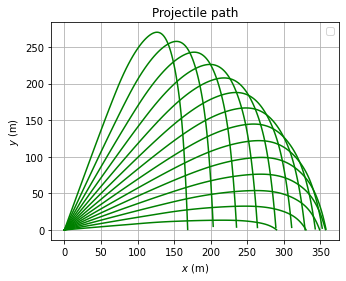

In [33]:
fig, ax = plt.subplots()
for i in range(15):
    ax.plot(Xa[i,:lengths[i]],Ya[i, :lengths[i]] , "g-")
ax.set_title(r"Projectile path")
ax.set_aspect("equal")
ax.grid(b=True)
ax.legend()
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.savefig("01 Path.png")

No handles with labels found to put in legend.


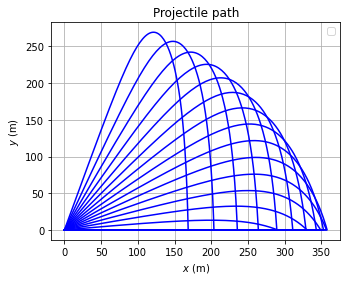

In [34]:
fig, ax = plt.subplots()
for i in range(15):
    ax.plot(z[i,:,0],z[i, :,1] , "b-")
ax.set_title(r"Projectile path")
ax.set_aspect("equal")
ax.grid(b=True)
ax.legend()
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.savefig("01 Path.png")

In [35]:
Xa = np.zeros((15,141))
Ya = np.zeros((15,141))
z = np.zeros((15,131,2))
lengths = []
for i in range(15):
    z[i,0:101], T = makeX(40, 130+5*i)
    x, y = onestep_no_figure(z[i])
    lengths.append(len(x))
    Xa[i,:len(x)]=x
    Ya[i,:len(y)]=y

No handles with labels found to put in legend.


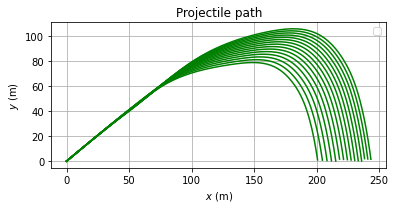

In [36]:
fig, ax = plt.subplots()
for i in range(15):
    ax.plot(Xa[i,:lengths[i]],Ya[i, :lengths[i]] , "g-")
ax.set_title(r"Projectile path")
ax.set_aspect("equal")
ax.grid(b=True)
ax.legend()
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.savefig("01 Path.png")

No handles with labels found to put in legend.


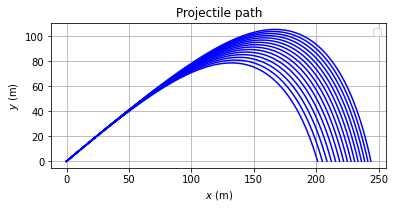

In [37]:
fig, ax = plt.subplots()
for i in range(15):
    ax.plot(z[i,0:101,0],z[i,0:101,1] , "b-")
ax.set_title(r"Projectile path")
ax.set_aspect("equal")
ax.grid(b=True)
ax.legend()
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.savefig("01 Path.png")